In [1]:
import torch
from d2l import torch as d2l
from torch import nn

In [2]:
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

In [3]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
net = vgg(conv_arch)

In [4]:
X = torch.randn(size=(3, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([3, 64, 112, 112])
Sequential output shape:	 torch.Size([3, 128, 56, 56])
Sequential output shape:	 torch.Size([3, 256, 28, 28])
Sequential output shape:	 torch.Size([3, 512, 14, 14])
Sequential output shape:	 torch.Size([3, 512, 7, 7])
Flatten output shape:	 torch.Size([3, 25088])
Linear output shape:	 torch.Size([3, 4096])
ReLU output shape:	 torch.Size([3, 4096])
Dropout output shape:	 torch.Size([3, 4096])
Linear output shape:	 torch.Size([3, 4096])
ReLU output shape:	 torch.Size([3, 4096])
Dropout output shape:	 torch.Size([3, 4096])
Linear output shape:	 torch.Size([3, 10])


In [5]:
def train_gpu(net, train_iter, test_iter, num_epochs, lr, num_gpus):
    if num_gpus == 0:
        devices = [torch.device('cpu')]
    else:
        devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    if num_gpus != 0:
        net = nn.DataParallel(net,device_ids = devices)
    trainer = torch.optim.Adam(net.parameters(),lr)
    loss = nn.CrossEntropyLoss()
    timer,num_epochs = d2l.Timer(),10
    animator = d2l.Animator('epoch','test acc',xlim = [1,num_epochs])
    for epoch in range(num_epochs):
        net.train()
        timer.start()
        for X,y in train_iter:
            trainer.zero_grad()
            if num_gpus != 0:
                X,y = X.to(devices[0]),y.to(devices[0])
            l = loss(net(X),y)
            l.backward()
            trainer.step()
        timer.stop()
        animator.add(epoch+1,(d2l.evaluate_accuracy_gpu(net,test_iter),))
    print(f'test acc: {animator.Y[0][-1]:.2f},{timer.avg():.1f} sec/epoch '
          f'on {str(devices)}')
                       

In [6]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, num_gpus):
    """Train a model with a GPU (defined in Chapter 6)."""
    if num_gpus == 0:
        devices = [torch.device('cpu')]
    else:
        devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print('training on ', devices)
    if num_gpus != 0:
        net = nn.DataParallel(net,device_ids = devices)
        net.to(torch.device("cuda"))
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator('epoch','test acc',xlim = [1,num_epochs])
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        net.train()
        timer.start()
        for X, y in train_iter:
            optimizer.zero_grad()
            if num_gpus != 0:
                X,y = X.to(devices[0]),y.to(devices[0])
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        timer.stop()
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1,(test_acc,))
    print(f'test acc: {animator.Y[0][-1]:.2f},{timer.avg():.1f} sec/epoch '
          f'on {str(devices)}')


/root/miniconda3/envs/myconda/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


training on  [device(type='cuda', index=0)]


RuntimeError: CUDA out of memory. Tried to allocate 50.00 MiB (GPU 0; 10.76 GiB total capacity; 9.40 GiB already allocated; 8.56 MiB free; 9.43 GiB reserved in total by PyTorch)

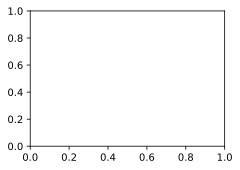

In [7]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)
lr, num_epochs, batch_size = 0.10, 10, 512
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
train_ch6(net, train_iter, test_iter, num_epochs, lr, 1)